## DSA210 Term Project – Eating Habits & Sleep Quality

In this notebook, we analyze how healthy eating habits are related to sleep quality and sleep duration.
The dataset consists of self-reported survey responses from 58 university students.

We will:

- Create a structured dataset from the survey
- Perform basic data cleaning and descriptive statistics
- Visualize the relationships between key variables (diet score, sleep quality, sleep duration, caffeine, etc.)
- Conduct hypothesis tests using correlation and t-tests
- Interpret p-values and discuss whether we reject or fail to reject the null hypotheses
- **Apply basic machine learning models to predict sleep quality outcomes based on dietary and lifestyle variables**
- **Evaluate model performance and compare results with statistical findings**

---

### Key variables:

- **diet_score (1–10)**: Self-rated healthy eating score  
- **sleep_score (1–10)**: Self-rated sleep quality  
- **sleep_hours**: Average hours of sleep per night  
- **healthy_diet**: Binary indicator (1 = diet_score > 6, 0 = otherwise)

We specifically test whether healthier eating habits are associated with better sleep quality.
Additionally, we explore whether sleep quality can be **predicted** using diet-related and lifestyle features through supervised machine learning methods.

---

This notebook also demonstrates the full data science workflow, including data preprocessing, feature engineering, statistical analysis, and **machine learning classification models**.

This cell imports all the libraries we will use for:

- data handling (pandas, numpy)
- visualization (matplotlib, seaborn)
- statistical tests (scipy)
- **machine learning (scikit-learn)**


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, ttest_ind

# Make plots a bit sharper and nicer
plt.rcParams["figure.dpi"] = 110
sns.set_style("whitegrid")


This cell manually creates the DataFrame "df" from the survey responses.
Each row is one participant and each column is a variable.


In [4]:
import pandas as pd

# 1) Updated dataset: read from Excel
path = "sleep_diet_dataset.xlsx"   # aynı klasördeyse böyle; değilse tam yol ver
df = pd.read_excel(path)

# 2) (Opsiyonel ama önerilir) Sayısal sütunları garanti numeric yap
numeric_cols = [
    "meals","calories","caffeine","hydration","diet_score",
    "sleep_hours","sleep_latency","wakeups","sleep_score",
    "exercise","screen"
]
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 3) Binary categories (aynı mantık)
df["healthy_diet"] = (df["diet_score"] > 6).astype(int)
df["good_sleep"]   = (df["sleep_score"] > 6).astype(int)

df.head()


,name,meals,calories,caffeine,hydration,diet_score,sleep_hours,sleep_latency,wakeups,sleep_score,exercise,screen,healthy_diet,good_sleep
0,Berre,3.0,2000.0,2,1.0,6,5.0,15.0,0.0,5.0,0,1.0,0,0
1,Ayşenur,2.5,1250.0,3,3.0,7,8.0,7.5,0.0,7.0,0,4.0,1,1
2,Damla,2.0,NaN,2,1.0,6,7.5,7.5,0.5,7.0,0,7.0,0,1
3,Deha,3.0,2500.0,1,7.0,7,7.0,45.0,0.0,6.0,1,4.0,1,0
4,Elif,2.0,1350.0,3,4.0,5,8.0,7.5,0.0,10.0,0,7.0,0,1


In [5]:
# This cell:
# 1) checks basic info (shape, missing values)
# 2) fills simple missing values (None) with column means for numeric columns.

print("Shape of the dataset (rows, columns):", df.shape)
print("\nMissing values per column:")
print(df.isna().sum())

# Fill missing numeric values with the mean of each column
for col in ["calories", "sleep_latency", "screen"]:
    df[col] = df[col].fillna(df[col].mean())

print("\nAfter simple imputation:")
print(df.isna().sum())


Shape of the dataset (rows, columns): (57, 14)

Missing values per column:
name             0
meals            0
calories         2
caffeine         0
hydration        0
diet_score       0
sleep_hours      0
sleep_latency    2
wakeups          0
sleep_score      0
exercise         0
screen           2
healthy_diet     0
good_sleep       0
dtype: int64

After simple imputation:
name             0
meals            0
calories         0
caffeine         0
hydration        0
diet_score       0
sleep_hours      0
sleep_latency    0
wakeups          0
sleep_score      0
exercise         0
screen           0
healthy_diet     0
good_sleep       0
dtype: int64


This cell:
- computes basic descriptive statistics for key numeric variables
- plots a correlation matrix (heatmap) to visualize linear relationships

Descriptive statistics (numeric variables):


,count,mean,std,min,25%,50%,75%,max
diet_score,57.0,5.561404,1.451816,2.0,5.0,6.000000,6.0,8.0
sleep_score,57.0,6.640351,1.687016,4.0,5.0,6.000000,7.0,10.0
sleep_hours,57.0,6.877193,1.392841,3.0,6.0,7.000000,8.0,10.0
caffeine,57.0,2.842105,1.473449,0.0,2.0,3.000000,4.0,6.0
hydration,57.0,4.780702,2.068077,1.0,3.0,5.000000,6.0,9.0
screen,57.0,5.327273,2.291713,0.0,4.0,5.327273,7.0,10.0


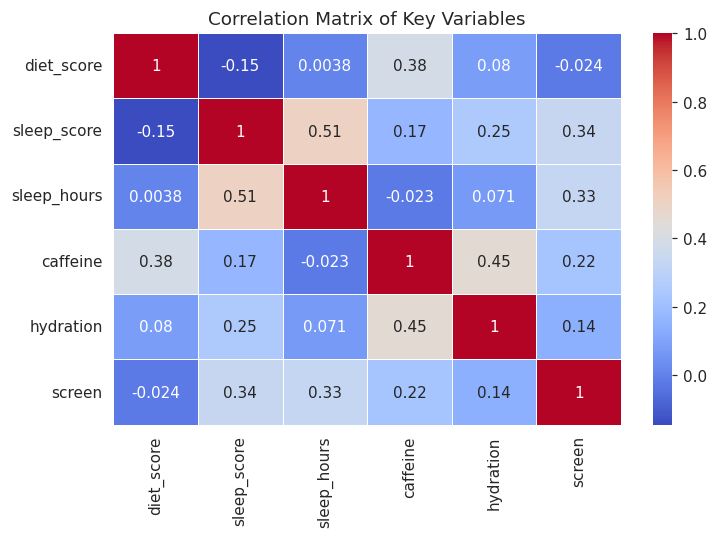

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind

numeric_cols = [
    "diet_score","sleep_score","sleep_hours",
    "caffeine","hydration","screen"
]

print("Descriptive statistics (numeric variables):")
display(df[numeric_cols].describe().T)

# Correlation matrix heatmap
plt.figure(figsize=(7,5))
sns.heatmap(
    df[numeric_cols].corr(),
    annot=True,
    cmap="coolwarm",
    linewidths=.5
)
plt.title("Correlation Matrix of Key Variables")
plt.tight_layout()
plt.show()



This cell creates several visualizations:
- scatter plots to explore pairwise relationships
- histograms to see the distribution of scores

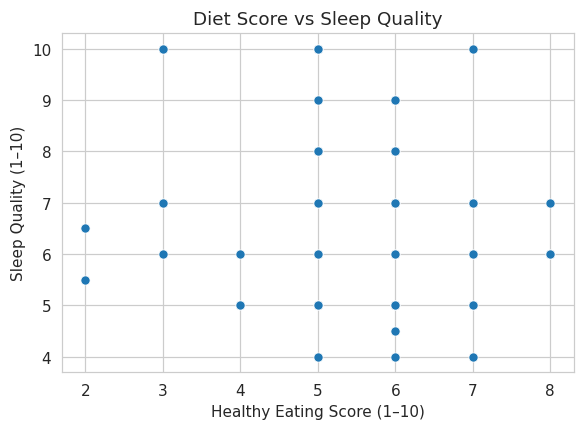

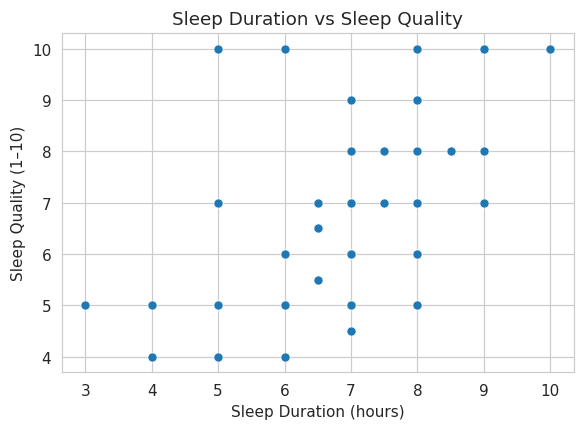

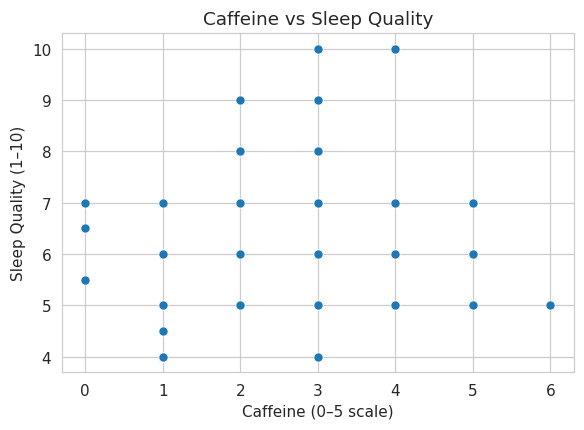

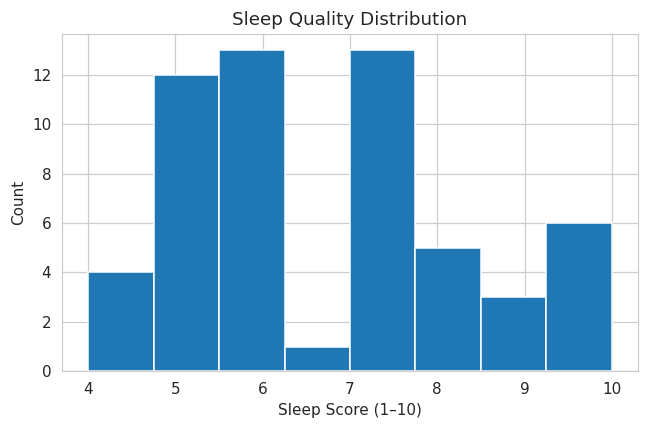

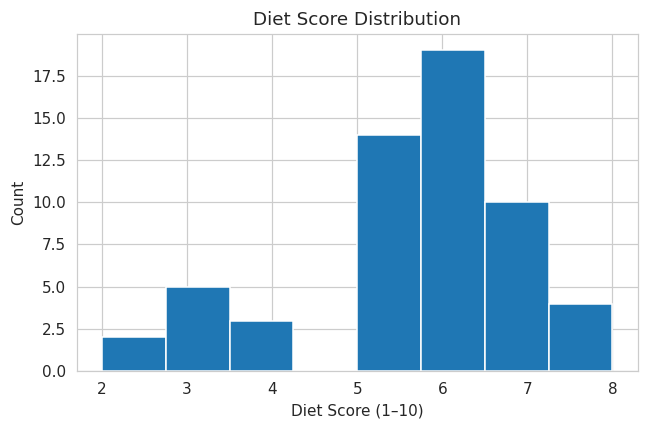

In [7]:

import matplotlib.pyplot as plt
import seaborn as sns

def scatter(x, y, xlabel=None, ylabel=None, title=None):
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x=x, y=y)
    plt.xlabel(xlabel or x)
    plt.ylabel(ylabel or y)
    if title:
        plt.title(title)
    plt.show()


# Diet score vs Sleep quality
scatter("diet_score", "sleep_score",
        "Healthy Eating Score (1–10)",
        "Sleep Quality (1–10)",
        "Diet Score vs Sleep Quality")

# Sleep duration vs Sleep quality
scatter("sleep_hours", "sleep_score",
        "Sleep Duration (hours)",
        "Sleep Quality (1–10)",
        "Sleep Duration vs Sleep Quality")

# Caffeine vs Sleep quality
scatter("caffeine", "sleep_score",
        "Caffeine (0–5 scale)",
        "Sleep Quality (1–10)",
        "Caffeine vs Sleep Quality")

# Histograms
plt.figure(figsize=(6,4))
df["sleep_score"].hist(bins=8)
plt.title("Sleep Quality Distribution")
plt.xlabel("Sleep Score (1–10)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
df["diet_score"].hist(bins=8)
plt.title("Diet Score Distribution")
plt.xlabel("Diet Score (1–10)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


This cell creates boxplots to compare the distribution of sleep quality
between diet categories (healthy vs unhealthy).

First, map the numeric category (0/1) to readable labels.

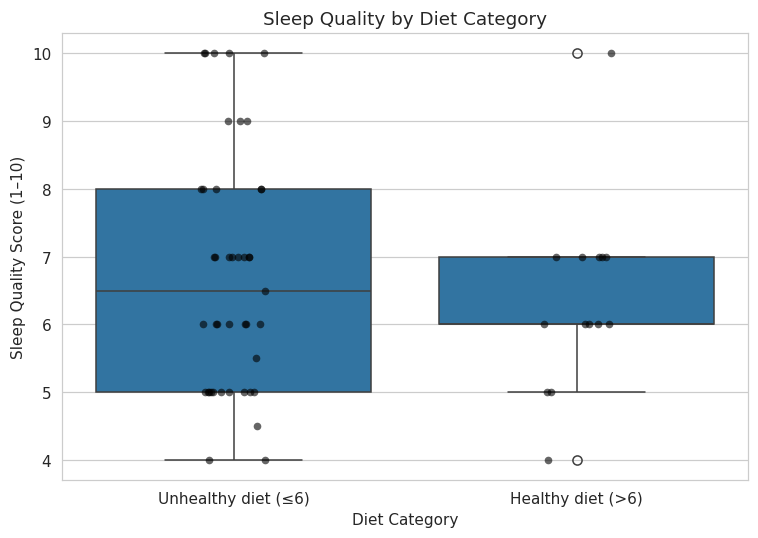

In [8]:

df["diet_category"] = df["healthy_diet"].map({0: "Unhealthy diet (≤6)", 1: "Healthy diet (>6)"})

plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="diet_category", y="sleep_score")
sns.stripplot(data=df, x="diet_category", y="sleep_score",
              color="black", alpha=0.6, jitter=0.1)  # show individual points

plt.title("Sleep Quality by Diet Category")
plt.xlabel("Diet Category")
plt.ylabel("Sleep Quality Score (1–10)")
plt.tight_layout()
plt.show()


This cell performs hypothesis testing and prints both r, t and p-values,
with short explanations.

H0: There is no relationship between healthy_diet (0/1) and sleep_score.
H1: There is a relationship.

In [9]:


from scipy.stats import pearsonr, ttest_ind

r, p = pearsonr(df["healthy_diet"], df["sleep_score"])

print("=== Pearson Correlation: Diet Category vs Sleep Quality ===")
print(f"Pearson r = {r:.3f}")
print(f"p-value   = {p:.3f}")
print()
print("Interpretation:")
print("- If p < 0.05, we reject H0 and say there is a significant relationship.")
print("- If p ≥ 0.05, we fail to reject H0 (no significant relationship).")

# Now compare mean sleep quality between healthy and unhealthy diet groups using a t-test.

healthy = df[df["healthy_diet"] == 1]["sleep_score"]
unhealthy = df[df["healthy_diet"] == 0]["sleep_score"]

t_stat, p_val = ttest_ind(healthy, unhealthy, equal_var=False)

print("\n=== Two-sample t-test: Healthy vs Unhealthy Diet (Sleep Quality) ===")
print(f"t-statistic = {t_stat:.3f}")
print(f"p-value     = {p_val:.3f}")
print()
print("Again, we compare the p-value with α = 0.05:")
print("- If p < 0.05 ⇒ significant difference between groups.")
print("- If p ≥ 0.05 ⇒ no significant difference between groups.")


=== Pearson Correlation: Diet Category vs Sleep Quality ===
Pearson r = -0.097
p-value   = 0.475

Interpretation:
- If p < 0.05, we reject H0 and say there is a significant relationship.
- If p ≥ 0.05, we fail to reject H0 (no significant relationship).

=== Two-sample t-test: Healthy vs Unhealthy Diet (Sleep Quality) ===
t-statistic = -0.815
p-value     = 0.422

Again, we compare the p-value with α = 0.05:
- If p < 0.05 ⇒ significant difference between groups.
- If p ≥ 0.05 ⇒ no significant difference between groups.


How to Interpret the p-value



- The p-value tells us how likely it is to observe our data (or more extreme) if the null hypothesis (H₀) is actually true.
- If **p < 0.05**, we usually say the result is *statistically significant* and we **reject H₀**.
- If **p ≥ 0.05**, we **fail to reject H₀**; this means we do not have strong enough evidence to claim an effect or relationship.

In [12]:
target = "good_sleep"

df_ml = df.dropna(subset=[target]).copy()

X = df_ml.drop(columns=[target, "name"], errors="ignore")
y = df_ml[target].astype(int)

num_cols = X.select_dtypes(include="number").columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

clf = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf.fit(X_train, y_train)

pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("ROC-AUC:", roc_auc_score(y_test, proba))


[[8 0]
 [1 6]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.86      0.92         7

    accuracy                           0.93        15
   macro avg       0.94      0.93      0.93        15
weighted avg       0.94      0.93      0.93        15

ROC-AUC: 0.9821428571428571


### Machine Learning Approach: Predicting Sleep Quality

In addition to statistical analysis, we apply a supervised machine learning approach to further investigate the relationship between dietary habits and sleep quality.

The goal of this section is to predict whether a student has **good sleep quality** based on diet-related and lifestyle variables. We formulate this task as a **binary classification problem**, where the target variable `good_sleep` is defined as:

- `1` if `sleep_score > 6` (good sleep quality)
- `0` otherwise

Before training the model, observations with missing values in the target variable are removed to ensure a valid learning process. The dataset is then separated into input features (diet score, sleep hours, caffeine intake, hydration level, screen time, etc.) and the target variable.

A **Logistic Regression model** is chosen as a baseline classifier due to its interpretability and suitability for binary outcomes. To follow best practices in machine learning, we use a **pipeline structure** that includes:

- Imputation of missing values
- Feature scaling for numerical variables
- Model training and evaluation

The dataset is split into training and test sets to assess the model’s generalization performance. Model performance is evaluated using classification metrics such as precision, recall, F1-score, confusion matrix, and ROC-AUC.

This machine learning analysis complements the earlier statistical findings by examining whether sleep quality can be reliably predicted from diet and lifestyle variables.


In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42))
])

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
proba_rf = rf.predict_proba(X_test)[:, 1]

print("\n=== RandomForest ===")
print("ROC-AUC:", roc_auc_score(y_test, proba_rf))
print(classification_report(y_test, pred_rf))



=== RandomForest ===
ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



### Bonus Machine Learning Model: Random Forest Classifier

In addition to Logistic Regression, we implement a **Random Forest classifier** as a secondary machine learning model to compare predictive performance.

Random Forest is an **ensemble learning method** that combines multiple decision trees to capture potential non-linear relationships and interactions among variables. Unlike Logistic Regression, which assumes a linear relationship between features and the target variable, Random Forest can model more complex patterns in the data.

The same preprocessing pipeline used in the Logistic Regression model is retained to ensure a fair comparison between models. The dataset is split into training and test sets using the same configuration, and model performance is evaluated using identical metrics, including classification report and ROC-AUC.

By comparing the results of Logistic Regression and Random Forest, we assess whether a more flexible, non-linear model provides meaningful performance improvements over a simpler and more interpretable baseline model.

This comparison allows us to balance **model interpretability** and **predictive performance**, which is a key consideration in applied data science projects.
